In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = TabularDataset(f'reformated3.csv')
train_data.head()

,SOC,V,I,T
0,100.000031,400.75,0.000000,15.5
1,100.000031,400.75,-0.270000,15.5
2,100.000031,400.75,-0.539999,15.5
3,100.000031,400.75,-0.809999,15.5
4,100.000031,400.75,-1.079998,15.5


In [3]:
label = 'SOC'
train_data[label].describe()

count    203215.000000
mean         69.761578
std          25.222992
min           0.000000
25%          49.803936
50%          76.078453
75%          91.764732
max         100.000031
Name: SOC, dtype: float64

In [4]:
predictor = TabularPredictor(label=label).fit(train_data)
'''
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 30*60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor = TabularPredictor(label=label).fit(
    train_data, time_limit=time_limit, auto_stack=True,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)
'''

No path specified. Models will be saved in: "AutogluonModels\ag-20230327_031227\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230327_031227\"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    203215
Train Data Columns: 3
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 69.76158, 25.22299)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of

[1000]	valid_set's rmse: 1.74292
[2000]	valid_set's rmse: 1.60919
[3000]	valid_set's rmse: 1.54674
[4000]	valid_set's rmse: 1.50969
[5000]	valid_set's rmse: 1.48511
[6000]	valid_set's rmse: 1.46847
[7000]	valid_set's rmse: 1.45462
[8000]	valid_set's rmse: 1.45069
[9000]	valid_set's rmse: 1.44485
[10000]	valid_set's rmse: 1.43654


	-1.4365	 = Validation score   (-root_mean_squared_error)
	27.56s	 = Training   runtime
	0.63s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 1.28824


	-1.2861	 = Validation score   (-root_mean_squared_error)
	4.02s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-1.8161	 = Validation score   (-root_mean_squared_error)
	24.96s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-1.7672	 = Validation score   (-root_mean_squared_error)
	4.71s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.8161	 = Validation score   (-root_mean_squared_error)
	8.14s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.8581	 = Validation score   (-root_mean_squared_error)
	95.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-1.5488	 = Validation score   (-root_mean_squared_error)
	0.67s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-2.2265	 = Validation score   (-root_mean_squared_error)
	69.37s	 = Training   runtime
	0.01s	 = Validation run

"\nimport autogluon.core as ag\n\nnn_options = {  # specifies non-default hyperparameter values for neural network models\n    'num_epochs': 10,  # number of training epochs (controls training time of NN models)\n    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)\n    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)\n    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)\n}\n\ngbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees\n    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)\n    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)\n}\n\nhyperparameters = {  # hyperparameter

In [5]:
test_data = TabularDataset(f'Data/Drive86_soc.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/Drive86_soc.csv | Columns = 4 / 4 | Rows = 5617 -> 5617


0    61.217506
1    60.327766
2    60.327766
3    60.327766
4    60.327766
Name: SOC, dtype: float32

In [6]:
predictor.evaluate(test_data, silent=True)

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -3.800385244187898,
 'mean_squared_error': -14.442928004241109,
 'mean_absolute_error': -2.965113730312255,
 'r2': 0.9210089399325663,
 'pearsonr': 0.9657744804388901,
 'median_absolute_error': -2.2280082740136713}

In [7]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,-3.266069,-1.858147,0.114241,0.016954,95.219966,0.114241,0.016954,95.219966,1,True,8
1,CatBoost,-3.279941,-1.767177,0.060843,0.003649,4.711075,0.060843,0.003649,4.711075,1,True,6
2,XGBoost,-3.300905,-1.548754,0.009487,0.003991,0.667421,0.009487,0.003991,0.667421,1,True,9
3,NeuralNetTorch,-3.353782,-2.226498,0.020944,0.007979,69.370696,0.020944,0.007979,69.370696,1,True,10
4,LightGBMLarge,-3.678880,-1.522988,0.031914,0.010972,1.596697,0.031914,0.010972,1.596697,1,True,11
5,WeightedEnsemble_L2,-3.800385,-1.255873,0.245890,0.111312,101.144448,0.002992,0.000000,0.286637,2,True,12
6,LightGBM,-3.839745,-1.286126,0.084775,0.026439,4.016839,0.084775,0.026439,4.016839,1,True,4
7,ExtraTreesMSE,-4.083083,-1.816104,0.488567,0.054665,8.139780,0.488567,0.054665,8.139780,1,True,7
8,RandomForestMSE,-4.123697,-1.816127,0.538599,0.072171,24.956614,0.538599,0.072171,24.956614,1,True,5
9,LightGBMXT,-4.332109,-1.436544,1.593062,0.634207,27.558897,1.593062,0.634207,27.558897,1,True,3


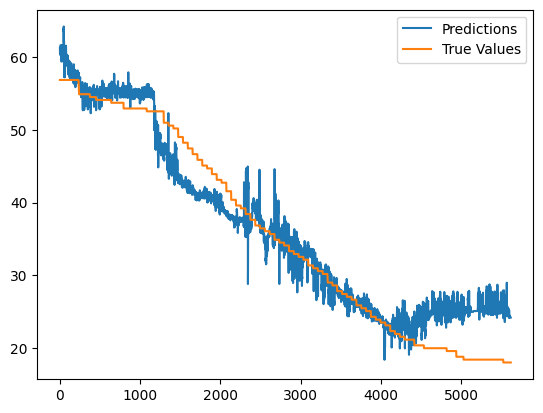

In [8]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()